# [BoardGameGeek Reviews](https://www.kaggle.com/jvanelteren/boardgamegeek-reviews)

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
from collections import Counter
from bs4 import BeautifulSoup
import nltk
import re
from textblob import TextBlob
from wordcloud import WordCloud
from nltk import word_tokenize 
from nltk.corpus import stopwords
from googletrans import Translator
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
import pickle
import string




## Load Data in Chunks
> * Sometimes your data file is so large you can’t load it into memory at all, even with compression. So how do you process it quickly?
> * By loading and then processing the data in chunks, you can load only part of the file into memory at any given time. And that means you can process files that don’t fit in memory.
> * Since it's a dataset of 13million records, I preferred loading in chunks

In [33]:
chunk_list = []
ave_bytes = 0

for index, chunk in enumerate(pd.read_csv('FinalProject/bgg-13m-reviews.csv/bgg-13m-reviews.csv', chunksize= 1000000),start=1):
# We add total memory per chunk to ave_bytes
    ave_bytes += chunk.memory_usage().sum()
    chunk_list.append(chunk)
df_reviews = pd.concat(chunk_list)
#df_reviews.columns

## Let's Explore the data

#### Number of Rows and Columns

In [34]:
df_reviews.shape

(13170073, 6)

#### DataTypes

In [35]:
df_reviews.dtypes

Unnamed: 0      int64
user           object
rating        float64
comment        object
ID              int64
name           object
dtype: object

#### "GAME REVIEW-RATING DATASET"

In [36]:
df_reviews

,Unnamed: 0,user,rating,comment,ID,name
0,0,sidehacker,10.0,NaN,13,Catan
1,1,Varthlokkur,10.0,NaN,13,Catan
2,2,dougthonus,10.0,"Currently, this sits on my list as my favorite...",13,Catan
3,3,cypar7,10.0,"I know it says how many plays, but many, many ...",13,Catan
4,4,ssmooth,10.0,NaN,13,Catan
...,...,...,...,...,...,...
13170068,3356495,pswissler,3.0,NaN,8256,LEGO Constructionary Game
13170069,3356496,Sprayoncrayon,3.0,"Lego created a version of Pictionary, only you...",8256,LEGO Constructionary Game
13170070,3356497,PhoenixSong,2.5,This game is very similar to Creationary. It c...,8256,LEGO Constructionary Game
13170071,3356498,tsantos,2.0,This game was really bad. Worst that I've pla...,8256,LEGO Constructionary Game


## Exploring Rating Column

#### There are 8202 different ratings in this huge dataset ....!!!!

In [37]:
df = df_reviews[['comment', 'rating']] 
series_rating = df['rating'].value_counts()
dict_reviews = {}
for i in series_rating.index:
    dict_reviews[i] = series_rating.get(key = i) 
print(len(dict_reviews))

8202


In [38]:
k = Counter(dict_reviews)
print("total ratings =", sum(k.values()),", unique ratings =", len(k.values()),", Before Elimining NaN Rows")


total ratings = 13170073 , unique ratings = 8202 , Before Elimining NaN Rows


In [39]:
k.most_common(15)

[(7.0, 2977370),
 (8.0, 2468632),
 (6.0, 1987008),
 (9.0, 1158917),
 (5.0, 923398),
 (10.0, 588170),
 (7.5, 582449),
 (4.0, 432745),
 (6.5, 400324),
 (8.5, 296297),
 (3.0, 221760),
 (5.5, 112108),
 (2.0, 106102),
 (9.5, 81319),
 (1.0, 63767)]

In [40]:
df_reviews.isnull().sum()

Unnamed: 0           0
user                66
rating               0
comment       10532317
ID                   0
name                 0
dtype: int64

#### Eliminating Records with **Empty Comments** as those rows won't help in modelling and exploring the rating column again

In [41]:
df_reviews_new = df_reviews.dropna()
df_reviews_new.shape

(2637756, 6)

In [42]:
df_new = df_reviews_new[['comment', 'rating']] 
series_rating_new = df_new['rating'].value_counts()
dict_reviews_new = {}
for i in series_rating_new.index:
    dict_reviews_new[i] = series_rating_new.get(key = i) 
len(dict_reviews_new)

3408

In [43]:
k_new = Counter(dict_reviews_new)
print("total ratings =", sum(k_new.values()),", unique ratings =", len(k_new.values()),", After Elimining NaN Rows")

total ratings = 2637756 , unique ratings = 3408 , After Elimining NaN Rows


In [44]:
k_new.most_common(15)

[(7.0, 525950),
 (8.0, 432375),
 (6.0, 393411),
 (9.0, 216637),
 (5.0, 211380),
 (10.0, 127325),
 (4.0, 119549),
 (7.5, 115838),
 (6.5, 85107),
 (3.0, 69442),
 (8.5, 62524),
 (2.0, 36905),
 (5.5, 28612),
 (9.5, 20466),
 (1.0, 19788)]

#### We can see that there are records with rating = 7.0 before and after elimination of records

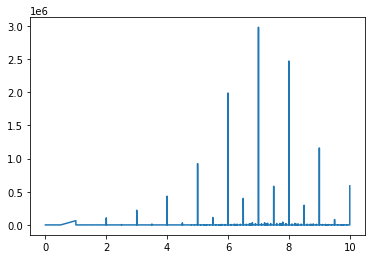

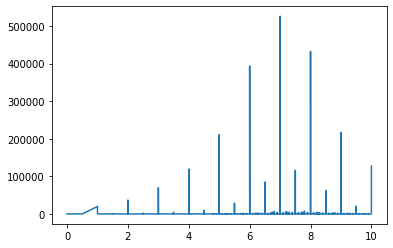

In [45]:
plt.plot(*zip(*sorted(dict_reviews.items())))
plt.show()
plt.plot(*zip(*sorted(dict_reviews_new.items())))
plt.show()

## Loading the New Data into csv file

In [46]:
df_reviews_new.to_csv('FinalProject/export_dataframe.csv', index=False, header=True)

## Preprocessing

In [31]:
def clean_text(text):
    text = text.lower()
    clean = re.compile('<.*?>')
    text = re.sub(clean,'',text)
    text = re.sub(r"""[,.;@#?!&$]+\ *"""," ",text, flags=re.VERBOSE)
    text = text.replace('\r\n', '-').replace('\n', ' ')
    check = text.replace(" ", "").isalpha()
    if check:
        text = [word for word in word_tokenize(text)]
    else:
        text = [word for word in word_tokenize(text) if word.isalpha()]
        
    return text

### Loading Data from csv in chunks and performing preprocessing and then changing the datatypes would help in better performance
> * Converting to lowercase
> * Removing html tags
> * Removing empty spaces
> * Removing punctuations
> * Removing newline characters
> * Removing numbers and symbols
> * All of the above done using "re"
> * Tokenization
> * Stopwords Removal(I have given my own liast of stop words as it was necessary to retain some words from the NLTK stopwords)
    > For example : 
    > * The game is good
    > * The game is not good
    > * Elimination of not may produce the same ratong for both the reviews. 

In [49]:
chunk_list1 = []
ave_bytes = 0
lancaster=LancasterStemmer()
#stemmer = SnowballStemmer("english")
STOPWORDS= set(["a","about","above","after","again","against","am","an","and","any","are","as","at","be","been","before","being","below","between","both","by","can","could","did","do","does","doing","down","during","each","few","for","from","further","had","has","have","having","he","he'd","he'll","he's","her","here","here's","hers","herself","him","himself","his","how","how's","i","i'd","i'll","i'm","i've","in","into","is","isn't","it","it's","its","itself","let's","me","more","myself","of","off","on","once","only","or","other","ought","our","ours" ,"ourselves","out","over","own","same","she","she'd","she'll","she's","should","so","some","such","than","that","that's","the","their","theirs","them","hemselves","then","there","there's","these","they","they'd","they'll","they're","they've","this","those","through","to","too","under","until","up","very","was","we","we'd","we'll","we're","we've","were","what","what's","when","when's","where","where's","which","while","who","who's","whom","why","why's","with","would","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","return","hes","heres","hows","im","its","lets","shes","thats","theres","theyll","theyre","theyve","were","whats","whens","wheres","whos","whys","youd","youll","youre","youve"])
reviews_rating = pd.DataFrame()
for index, chunk in enumerate(pd.read_csv('FinalProject/export_dataframe.csv', chunksize= 500000),start=1):
# We add total memory per chunk to ave_bytes
    ave_bytes += chunk.memory_usage().sum()
    chunk['comment'] = chunk['comment'].apply(clean_text)
    #chunk['comment'] = chunk['comment'].apply(lambda x: str(TextBlob(x).correct()))
    #STOPWORDS = set(stopwords.words('english'))
    STOPWORDS_dict = dict.fromkeys(STOPWORDS, 0)
    chunk['comment'] = chunk['comment'].apply(lambda x: [word for word in x if word not in STOPWORDS_dict])   
    print("index",index)
    chunk_list1.append(chunk)
reviews_rating = pd.concat(chunk_list1)


index 1
index 2
index 3
index 4
index 5
index 6


In [50]:
d1 = dict.fromkeys(reviews_rating.select_dtypes(np.int64).columns, np.int32)
d2 = dict.fromkeys(reviews_rating.select_dtypes(np.float64).columns, np.float32)
reviews_rating = reviews_rating.astype(d1)
reviews_rating = reviews_rating.astype(d2)


## Data after Preprocessing

In [51]:
reviews_rating.head()

,Unnamed: 0,user,rating,comment,ID,name
0,2,dougthonus,10.0,"[currently, sits, my, list, my, favorite, game]",13,Catan
1,3,cypar7,10.0,"[know, says, many, plays, but, many, many, unc...",13,Catan
2,7,hreimer,10.0,"[will, never, tire, game, awesome]",13,Catan
3,11,daredevil,10.0,"[probably, best, game, ever, played, requires,...",13,Catan
4,16,hurkle,10.0,"[fantastic, game, got, hooked, games, all]",13,Catan


## Pickle the Data
> Pickle in Python is primarily used in serializing and deserializing a Python object structure. In other words, it's the process of converting a Python object into a byte stream to store it in a file/database, maintain program state across sessions, or transport data over the network.

In [52]:
with open('reviews_rating.pickle', 'wb') as r:
    pickle.dump(reviews_rating, r)

In [13]:
dbfile = open('reviews_rating.pickle', 'rb')      
reviews_rating_pickled = pickle.load(dbfile) 

In [14]:
reviews_rating_pickled.head()

,Unnamed: 0,user,rating,comment,ID,name
0,2,dougthonus,10.0,"[currently, sits, my, list, my, favorite, game]",13,Catan
1,3,cypar7,10.0,"[know, says, many, plays, but, many, many, unc...",13,Catan
2,7,hreimer,10.0,"[will, never, tire, game, awesome]",13,Catan
3,11,daredevil,10.0,"[probably, best, game, ever, played, requires,...",13,Catan
4,16,hurkle,10.0,"[fantastic, game, got, hooked, games, all]",13,Catan


In [15]:
reviews_rating_pickled['comment'] = reviews_rating_pickled['comment'].apply(lambda x: ' '.join(word for word in x))
reviews_rating_pickled

,Unnamed: 0,user,rating,comment,ID,name
0,2,dougthonus,10.0,currently sits my list my favorite game,13,Catan
1,3,cypar7,10.0,know says many plays but many many uncounted l...,13,Catan
2,7,hreimer,10.0,will never tire game awesome,13,Catan
3,11,daredevil,10.0,probably best game ever played requires just t...,13,Catan
4,16,hurkle,10.0,fantastic game got hooked games all,13,Catan
...,...,...,...,...,...,...
2637751,3356493,BonnieD24,3.0,horrible party game dumping one,8256,LEGO Constructionary Game
2637752,3356494,asm71,3.0,difficult build anything all included pieces,8256,LEGO Constructionary Game
2637753,3356496,Sprayoncrayon,3.0,lego created version pictionary limited number...,8256,LEGO Constructionary Game
2637754,3356497,PhoenixSong,2.5,game similar creationary comes different cards...,8256,LEGO Constructionary Game


### Top 10 frequent words

In [16]:
freq =  pd.Series(' '.join(reviews_rating_pickled['comment']).split()).value_counts()[:10]
freq

game     2557071
but      1091798
play      745820
not       619836
my        523443
like      521576
fun       519377
one       483035
good      399486
games     383088
dtype: int64

### Top 10 rare words

In [17]:
rare = pd.Series(' '.join(reviews_rating_pickled['comment']).split()).value_counts()[-10:]
rare

unfortuntaley    1
papildymų        1
unespicable      1
jutalmazása      1
식상하게             1
sociétal         1
manuerability    1
dwarvy           1
hüttendissing    1
傳送到地圖上任一位置       1
dtype: int64

## Shuffle the Data before Training

In [18]:
reviews_rating_pickled = reviews_rating_pickled.sample(frac=1).reset_index(drop=True)
reviews_rating_pickled

,Unnamed: 0,user,rating,comment,ID,name
0,4669605,sabbath_,7.2,xxxxx,25554,Notre Dame
1,2632785,The Monstrous Jake,8.0,really like system ca put my finger but enjoy ...,1782,Ancients
2,179445,religon,9.0,clever cooperative game three levels difficult...,30549,Pandemic
3,510479,Android,4.0,group players just mood but one just sit well ...,296,Medieval Merchant
4,2891277,chuckles2000,8.0,best game awful zero handle strategy maybe par...,172,For Sale
...,...,...,...,...,...,...
2637751,2282453,Mangeluz,9.5,quite fun hard time remembering last used ninjas,164448,Ninja All-Stars
2637752,322626,i7dealer,7.0,played times now bumped my rating little good ...,1315,Africa
2637753,8777019,thesama,7.0,light civ game enjopyable but perhaps bit ligh...,17161,Tempus
2637754,8580199,PoisonApple,9.0,better time selection titles much easier names...,36553,Time's Up! Title Recall!


## Sampling

In [19]:
reviews_rating_sample = reviews_rating_pickled.sample(frac=0.25).reset_index(drop=True)
reviews_rating_sample

,Unnamed: 0,user,rating,comment,ID,name
0,642160,Steve Carey,6.00,somewhat dubious game first but my surprise en...,172547,Queen's Architect
1,700413,Matthias_K,8.00,fun much deeper appears surface puzzly unique ...,161226,The Builders: Antiquity
2,7545398,ryanabrams,8.00,done poor job adding plays but easily my most ...,925,Werewolf
3,5293664,The Innocent,7.00,surprised good game captures creeping dread al...,146652,Legendary Encounters: An Alien Deck Building Game
4,2901370,ocp_001,6.00,rating comes my memory game child,7563,Jaws
...,...,...,...,...,...,...
659434,4719607,Maximuss,2.00,sometimes find rating system bgg little wonky ...,483,Diplomacy
659435,9723749,flolem,8.25,traded montreal math trade,123499,City of Iron
659436,6015077,cnidius,7.00,nice refreshing game,21882,Blue Moon City
659437,9342815,benshever,5.00,pretty good game wouldn t mind playing suppose,592,Spades


## Splitting the data into Train and Test

In [20]:
X = reviews_rating_sample['comment']
y = reviews_rating_sample['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 0)

In [21]:
vectorizer1 = TfidfVectorizer()
train_vectors = vectorizer1.fit_transform(X_train)
with open('Vocab.pickle', 'wb') as v:
    pickle.dump(vectorizer1, v)
vectorizer2 = TfidfVectorizer(vocabulary=vectorizer1.vocabulary_)
test_vectors = vectorizer2.fit_transform(X_test)
print(train_vectors.shape, test_vectors.shape)
#print(vectorizer1, vectorizer2)

(593495, 184742) (65944, 184742)


## Regression Models
> * As the Rating Column values are continuous, I used Regression Models for Training the Data
> * Calculated respective MSE and r2_score metrics

### Linear Regression

In [22]:
linear_regression = LinearRegression()
linear_regression.fit(train_vectors, y_train)
with open('LinearRegression.pickle', 'wb') as l:
    pickle.dump(linear_regression, l)
y_pred = linear_regression.predict(test_vectors)


In [23]:

print('Mean squared error: %.2f'% mean_squared_error(y_test,y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test,y_pred))


Mean squared error: 2.96
Coefficient of determination: 0.06


### Lasso Regression (Linear Model trained with L1 prior as regularizer)

#### alpha = 0.1

In [24]:
lasso_model1 = linear_model.Lasso(alpha=0.1)
lasso_model1.fit(train_vectors, y_train)
with open('Lasso.pickle1', 'wb') as lasso1:
    pickle.dump(lasso_model1, lasso1)
y_pred_lasso1 = lasso_model1.predict(test_vectors)

In [25]:
print('Mean squared error: %.2f'% mean_squared_error(y_test,y_pred_lasso1))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test,y_pred_lasso1))

Mean squared error: 3.16
Coefficient of determination: -0.00


#### alpha = 0.01 

In [26]:
lasso_model2 = linear_model.Lasso(alpha=0.01)
lasso_model2.fit(train_vectors, y_train)
with open('Lasso.pickle2', 'wb') as lasso2:
    pickle.dump(lasso_model2, lasso2)
y_pred_lasso2 = lasso_model2.predict(test_vectors)

In [27]:
print('Mean squared error: %.2f'% mean_squared_error(y_test,y_pred_lasso2))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test,y_pred_lasso2))

Mean squared error: 3.10
Coefficient of determination: 0.02


### Ridge Regression

In [28]:
ridge = Ridge(alpha=1.0)
ridge.fit(train_vectors, y_train)
with open('Ridge.pickle', 'wb') as rr:
    pickle.dump(ridge, rr)
y_pred_ridge = ridge.predict(test_vectors)

In [29]:
print('Mean squared error: %.2f'% mean_squared_error(y_test,y_pred_ridge))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test,y_pred_ridge))

Mean squared error: 2.07
Coefficient of determination: 0.35


## Conclusion
As the MSE of Ridge Regression Model is the best value among all, I choose Ridge Regression for predict the reviews


In [44]:
file = open('Vocab.pickle', 'rb')      
vocab_pickled = pickle.load(file) 
vectorizer = TfidfVectorizer(vocabulary=vocab_pickled.vocabulary_)
model = open('Ridge.pickle', 'rb')      
ridge_pickled = pickle.load(model) 
comment = "The GaMe is gOOd and creates fun while playing..!!"
comment = clean_text(comment)
STOPWORDS= set(["a","about","above","after","again","against","am","an","and","any","are","as","at","be","been","before","being","below","between","both","by","can","could","did","do","does","doing","down","during","each","few","for","from","further","had","has","have","having","he","he'd","he'll","he's","her","here","here's","hers","herself","him","himself","his","how","how's","i","i'd","i'll","i'm","i've","in","into","is","isn't","it","it's","its","itself","let's","me","more","myself","of","off","on","once","only","or","other","ought","our","ours" ,"ourselves","out","over","own","same","she","she'd","she'll","she's","should","so","some","such","than","that","that's","the","their","theirs","them","hemselves","then","there","there's","these","they","they'd","they'll","they're","they've","this","those","through","to","too","under","until","up","very","was","we","we'd","we'll","we're","we've","were","what","what's","when","when's","where","where's","which","while","who","who's","whom","why","why's","with","would","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","return","hes","heres","hows","im","its","lets","shes","thats","theres","theyll","theyre","theyve","were","whats","whens","wheres","whos","whys","youd","youll","youre","youve"])
STOPWORDS_dict = dict.fromkeys(STOPWORDS, 0)
comment = [word for word in comment if word not in STOPWORDS_dict]
comment = ' '.join(word for word in comment)
p = vectorizer.fit_transform([comment])
round(ridge_pickled.predict(p)[0],2)


7.95

## Challenges
* Analyzing the dataset to decide which kind of model to choose among Regression and Classification Models.
* Reading a large data set was one of the challenges which was overcome by using concept of chunks and random sampling. 25% of the cleaned and processed dataset was used for training the models.
* There were about 8000 unique values for rating column. Since I finally got stick to Regression I kept the ratings as itself and used different Regression Models and picking one from them was challenging as all the MSE values were almost close to each other.

## Reference Links
* https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
* https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4
* https://medium.com/@abirj/text-analysis-and-classification-of-reviews-in-python-f4859e68b6cb
* https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
* https://www.kaggle.com/selener/multi-class-text-classification-tfidf
* https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/
* https://towardsdatascience.com/multi-class-text-classification-with-sklearn-and-nltk-in-python-a-software-engineering-use-case-779d4a28ba5
* https://stackabuse.com/overview-of-classification-methods-in-python-with-scikit-learn/
* http://www.ds100.org/sp17/assets/notebooks/linear_regression/Feature_Engineering_Part1.html#Mapping-from-Domain-to-Range
* https://towardsdatascience.com/understanding-feature-engineering-part-1-continuous-numeric-data-da4e47099a7b
* https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114
* https://www.analyticsvidhya.com/blog/2015/11/8-ways-deal-continuous-variables-predictive-modeling/